
-----------------
***Backtest Optimization Script***

-----------------


**Process** 
1. **Returns Matrix**: 

- Generate daily resampled returns for each asset.

2. **Covariance Matrix**: 

- Calculate using **Spearman correlation** for asset relationships.


3. **Portfolio Optimization**:
  
   - **Equal Weights**: 
      
      - Allocate equal proportions to all assets.
   
   - **Mean-Variance Optimization (MVO)**:

      - Optimize weights to maximize returns and minimize risk (Variance).

--------------------

**Input**
- **CSV File** with:
  - **Slug**: Asset name or identifier.
  - **Return**: Daily strategy returns for each asset.
  - **Date**: Timeline of daily returns.

**Output**
- **Subplots** comparing Equal-Weighted vs. MVO portfolio values.
- **Optimized Weights** printed for each method.

**Usage**
1. Replace `'Total Backtest 12H.csv'` with your CSV file path.
2. Run the script to visualize and analyze portfolio performance.


Example:

   | Slug     | EntryTime   | ExitDate    | Return  |
   |----------|-------------|-------------|---------|
   | Bitcoin  | 2023-01-01  | 2023-01-02  | 0.012   |
   | Ethereum | 2023-01-01  | 2023-01-02  | 0.015   |
   | Cardano  | 2023-01-02  | 2023-01-03  | 0.008   |


---------------------
###### *  *If you have Several Dataset in different csv files , you must combine them to Long Dataset and work with combined Dataset*
###### *  *For More Information Please Look at the Comments to Follow the Structure Easier*

---------------------



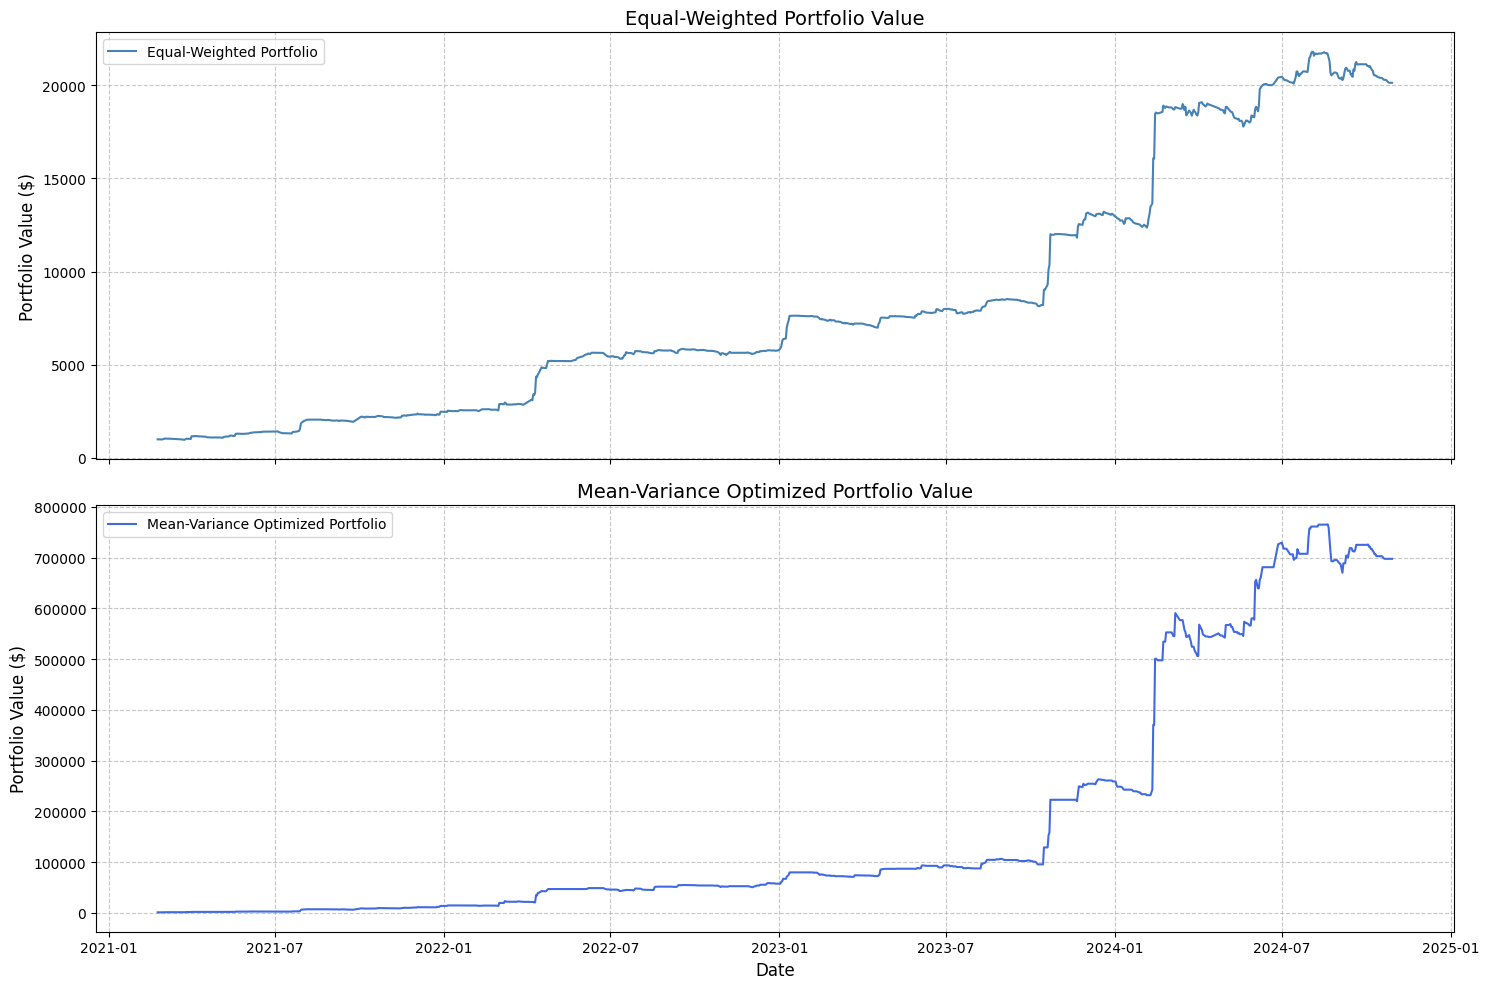


Equal-Weighted Portfolio Weights:
AAVE: 2.439%
ADA: 2.439%
APT: 2.439%
ARB: 2.439%
ATOM: 2.439%
AVAX: 2.439%
BCH: 2.439%
BNB: 2.439%
BTC: 2.439%
DOGE: 2.439%
DOT: 2.439%
ETC: 2.439%
ETH: 2.439%
FDUSD: 2.439%
FET: 2.439%
FIL: 2.439%
FTM: 2.439%
HBAR: 2.439%
ICP: 2.439%
IMX: 2.439%
INJ: 2.439%
KAS: 2.439%
LINK: 2.439%
LTC: 2.439%
NEAR: 2.439%
OP: 2.439%
PEPE: 2.439%
RENDER: 2.439%
RUNE: 2.439%
SHIB: 2.439%
SOL: 2.439%
STX: 2.439%
SUI: 2.439%
TAO: 2.439%
TRX: 2.439%
UNI: 2.439%
VET: 2.439%
WIF: 2.439%
XLM: 2.439%
XMR: 2.439%
XRP: 2.439%

Mean-Variance Optimized Portfolio Weights:
AAVE: 0.000%
ADA: 0.000%
APT: 0.000%
ARB: 0.000%
ATOM: 0.000%
AVAX: 8.846%
BCH: 0.000%
BNB: 0.000%
BTC: 0.000%
DOGE: 3.410%
DOT: 0.000%
ETC: 0.000%
ETH: 0.000%
FDUSD: 0.000%
FET: 9.333%
FIL: 8.103%
FTM: 7.934%
HBAR: 0.000%
ICP: 0.000%
IMX: 0.000%
INJ: 5.310%
KAS: 0.000%
LINK: 0.000%
LTC: 0.000%
NEAR: 3.119%
OP: 0.000%
PEPE: 5.482%
RENDER: 0.000%
RUNE: 18.293%
SHIB: 7.463%
SOL: 9.841%
STX: 0.000%
SUI: 0.000%
TAO:

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from skfolio.optimization import EqualWeighted

def read_and_prepare_dataset(csv_file):
    """
    Reads and preprocesses the dataset.

    Parameters:
    - csv_file: Path to the CSV file containing asset returns.

    Returns:
    - returns_matrix: A DataFrame with a matrix of asset returns.
    """
    df = pd.read_csv(csv_file, parse_dates=['EntryTime', 'ExitDate']).fillna(0)

    # Prepare relevant columns
    cols = ['slug', 'EntryTime', 'ExitDate', 'return']

    # Format EntryTime and ExitDate as strings
    df['EntryTime'] = df['EntryTime'].dt.strftime('%Y-%m-%d')
    df['ExitDate'] = df['ExitDate'].dt.strftime('%Y-%m-%d')

    # Create a DataFrame and sort
    return_df = df[cols].sort_values(by=['slug', 'EntryTime']).reset_index(drop=True)

    # Pivot to create a returns matrix
    returns_matrix = return_df.pivot_table(
        index='EntryTime',   # Index is EntryTime
        columns='slug',      # Columns are slugs (assets)
        values='return'      # Values are the returns
    ).fillna(0)

    # Convert index to datetime and sort
    returns_matrix.index = pd.to_datetime(returns_matrix.index)
    returns_matrix = returns_matrix.sort_index()

    return returns_matrix

def equal_weighted_portfolio(returns_matrix, initial_investment=1000):
    """
    Calculates portfolio performance using an equal-weighted strategy.

    Parameters:
    - returns_matrix: DataFrame of asset returns.
    - initial_investment: Initial portfolio value.

    Returns:
    - portfolio_value: Series of portfolio values over time.
    - weights: Array of weights for the assets.
    """
    equal_weighted_portfolio = EqualWeighted()
    optimized_equal = equal_weighted_portfolio.fit(returns_matrix)
    equal_weights = optimized_equal.weights_

    portfolio_returns = returns_matrix.dot(equal_weights)
    portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

    return portfolio_value, equal_weights

def mean_variance_optimized_portfolio(returns_matrix, initial_investment=1000, risk_aversion=1):
    """
    Calculates portfolio performance using mean-variance optimization.

    Parameters:
    - returns_matrix: DataFrame of asset returns.
    - initial_investment: Initial portfolio value.
    - risk_aversion: Risk-aversion parameter.

    Returns:
    - portfolio_value: Series of portfolio values over time.
    - weights: Array of weights for the assets.
    """
    spearman_corr = returns_matrix.corr(method='spearman')
    variances = returns_matrix.var()
    covariance_matrix = spearman_corr * variances.values[:, None]

    expected_returns = returns_matrix.mean()

    def mvo_objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        return portfolio_variance - risk_aversion * portfolio_return

    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(0, 1) for _ in range(len(returns_matrix.columns))]
    initial_guess = np.ones(len(returns_matrix.columns)) / len(returns_matrix.columns)

    result = minimize(
        mvo_objective,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    mvo_weights = result.x

    portfolio_returns = returns_matrix.dot(mvo_weights)
    portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

    return portfolio_value, mvo_weights

# Example usage
if __name__ == "__main__":
    csv_file = 'Total Backtest 12H.csv'
    initial_investment = 1000

    # Step 1: Read and prepare dataset
    returns_matrix = read_and_prepare_dataset(csv_file)

    # Step 2: Equal-Weighted Portfolio
    equal_portfolio_value, equal_weights = equal_weighted_portfolio(returns_matrix, initial_investment)

    # Step 3: Mean-Variance Optimized Portfolio
    mvo_portfolio_value, mvo_weights = mean_variance_optimized_portfolio(returns_matrix, initial_investment)

    # Plotting results
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Equal-weighted plot
    axes[0].plot(equal_portfolio_value.index, equal_portfolio_value, label="Equal-Weighted Portfolio", color='steelblue')
    axes[0].set_title("Equal-Weighted Portfolio Value", fontsize=14)
    axes[0].set_ylabel("Portfolio Value ($)", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(loc="upper left", fontsize=10)

    # MVO plot
    axes[1].plot(mvo_portfolio_value.index, mvo_portfolio_value, label="Mean-Variance Optimized Portfolio", color='royalblue')
    axes[1].set_title("Mean-Variance Optimized Portfolio Value", fontsize=14)
    axes[1].set_xlabel("Date", fontsize=12)
    axes[1].set_ylabel("Portfolio Value ($)", fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].legend(loc="upper left", fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print weights
    print("\nEqual-Weighted Portfolio Weights:")
    for asset, weight in zip(returns_matrix.columns, equal_weights):
        print(f"{asset}: {weight:.3%}")

    print("\nMean-Variance Optimized Portfolio Weights:")
    for asset, weight in zip(returns_matrix.columns, mvo_weights):
        print(f"{asset}: {weight:.3%}")


In [36]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from skfolio.optimization import EqualWeighted

def read_and_prepare_dataset(csv_file):
    """
    Reads and preprocesses the dataset.

    Parameters:
    - csv_file: Path to the CSV file containing asset returns.

    Returns:
    - returns_matrix: A DataFrame with a matrix of asset returns.
    """
    df = pd.read_csv(csv_file, parse_dates=['EntryTime', 'ExitDate']).fillna(0)

    # Prepare relevant columns
    cols = ['slug', 'EntryTime', 'ExitDate', 'return']

    # Format EntryTime and ExitDate as strings
    df['EntryTime'] = df['EntryTime'].dt.strftime('%Y-%m-%d')
    df['ExitDate'] = df['ExitDate'].dt.strftime('%Y-%m-%d')

    # Create a DataFrame and sort
    return_df = df[cols].sort_values(by=['slug', 'EntryTime']).reset_index(drop=True)

    # Pivot to create a returns matrix
    returns_matrix = return_df.pivot_table(
        index='EntryTime',   # Index is EntryTime
        columns='slug',      # Columns are slugs (assets)
        values='return'      # Values are the returns
    ).fillna(0)

    # Convert index to datetime and sort
    returns_matrix.index = pd.to_datetime(returns_matrix.index)
    returns_matrix = returns_matrix.sort_index()

    return returns_matrix

def equal_weighted_portfolio(returns_matrix, initial_investment=1000):
    """
    Calculates portfolio performance using an equal-weighted strategy.

    Parameters:
    - returns_matrix: DataFrame of asset returns.
    - initial_investment: Initial portfolio value.

    Returns:
    - portfolio_value: Series of portfolio values over time.
    - weights: Array of weights for the assets.
    """
    equal_weighted_portfolio = EqualWeighted()
    optimized_equal = equal_weighted_portfolio.fit(returns_matrix)
    equal_weights = optimized_equal.weights_

    portfolio_returns = returns_matrix.dot(equal_weights)
    portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

    return portfolio_value, equal_weights

if __name__ == "__main__":
    csv_file = 'Total Backtest 12H.csv'
    initial_investment = 1000

    # Step 1: Read and prepare dataset
    returns_matrix = read_and_prepare_dataset(csv_file)

    # Step 2: Equal-Weighted Portfolio
    equal_portfolio_value, equal_weights = equal_weighted_portfolio(returns_matrix, initial_investment)

In [37]:
equal_portfolio_value

EntryTime
2021-02-23      990.263439
2021-02-26      986.354169
2021-02-28      983.891970
2021-03-03     1034.571097
2021-03-04     1031.221670
                  ...     
2024-10-25    20148.697496
2024-10-26    20134.052727
2024-10-27    20131.043673
2024-10-28    20131.043673
2024-10-29    20130.982275
Length: 810, dtype: float64

In [43]:
from skfolio.optimization  import MeanRisk , ObjectiveFunction
from skfolio import RiskMeasure
import pandas as pd
import numpy as np

def mean_risk_optimized_portfolio(returns_matrix, initial_investment=1000, risk_measure=None,
                                  risk_aversion=1.0, min_weights=0.0, max_weights=1.0,
                                  budget=1.0, min_return=None, max_tracking_error=None):
    """
    Calculates portfolio performance using Mean-Risk Optimization with flexible parameters.

    Parameters:
    - returns_matrix: DataFrame of asset returns.
    - initial_investment: Initial portfolio value.
    - risk_measure: Risk measure for the portfolio (e.g., 'Variance').
    - risk_aversion: Risk-aversion parameter.
    - min_weights: Minimum weight for any asset (default: 0.0).
    - max_weights: Maximum weight for any asset (default: 1.0).
    - budget: Total budget constraint (default: 1.0).
    - min_return: Minimum return constraint (optional).
    - max_tracking_error: Maximum tracking error constraint (optional).

    Returns:
    - portfolio_value: Series of portfolio values over time.
    - weights: Array of weights for the assets.
    """
    # Configure the MeanRisk optimizer
    optimizer = MeanRisk(
        risk_measure=RiskMeasure.VARIANCE,
        objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
        risk_aversion=risk_aversion,
        min_weights=min_weights,
        max_weights=max_weights,

        min_return=min_return,
        max_tracking_error=max_tracking_error
    )

    # Fit the optimizer to the returns matrix
    optimized_result = optimizer.fit(returns_matrix)
    optimized_weights = optimized_result.weights_

    # Calculate portfolio returns and value
    portfolio_returns = returns_matrix.dot(optimized_weights)
    portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

    return portfolio_value, optimized_weights
portfolio_value, optimized_weights = mean_risk_optimized_portfolio(
        returns_matrix,
        initial_investment=initial_investment,
        risk_measure='Variance',
        risk_aversion=1.0,
        min_weights=0.01,  # Minimum weight of 1%
        max_weights=0.5,   # Maximum weight of 50%
        min_return=0.02    # Minimum expected return of 2%
    )

AttributeError: 'str' object has no attribute 'is_annualized'

In [41]:
def mean_variance_optimized_portfolio(returns_matrix, initial_investment=1000, risk_aversion=1):
    """
    Calculates portfolio performance using mean-variance optimization.

    Parameters:
    - returns_matrix: DataFrame of asset returns.
    - initial_investment: Initial portfolio value.
    - risk_aversion: Risk-aversion parameter.

    Returns:
    - portfolio_value: Series of portfolio values over time.
    - weights: Array of weights for the assets.
    """
    spearman_corr = returns_matrix.corr(method='spearman')
    variances = returns_matrix.var()
    covariance_matrix = spearman_corr * variances.values[:, None]

    expected_returns = returns_matrix.mean()

    def mvo_objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        return portfolio_variance - risk_aversion * portfolio_return

    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(0, .5) for _ in range(len(returns_matrix.columns))]
    initial_guess = np.ones(len(returns_matrix.columns)) / len(returns_matrix.columns)

    result = minimize(
        mvo_objective,
        initial_guess,
        method='COBYLA',
        bounds=bounds,
        constraints=constraints
    )

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    mvo_weights = result.x

    portfolio_returns = returns_matrix.dot(mvo_weights)
    portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

    return portfolio_value, mvo_weights

mvo_portfolio_value, mvo_weights = mean_variance_optimized_portfolio(returns_matrix, initial_investment)
mvo_portfolio_value


ValueError: Constraints of type 'eq' not handled by COBYLA.

Initial Guess: [0.03540533 0.09178205 0.02306976 0.08542451 0.07639    0.05824167
 0.0778384  0.01599059 0.0406117  0.01150194 0.00557606 0.00021271
 0.07731202 0.08087945 0.00797791 0.02170924 0.09780269 0.05193579
 0.06407096 0.06232354 0.01433524 0.02190436 0.09112049 0.02563971
 0.04042829 0.02172257 0.0801952  0.0593268  0.07091143 0.08781449
 0.05844558 0.06860425 0.05543515 0.05551207 0.09298901 0.0015728
 0.02250055 0.08036512 0.08004534 0.09944109 0.03354901]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.006354098327928599
            Iterations: 18
            Function evaluations: 756
            Gradient evaluations: 18


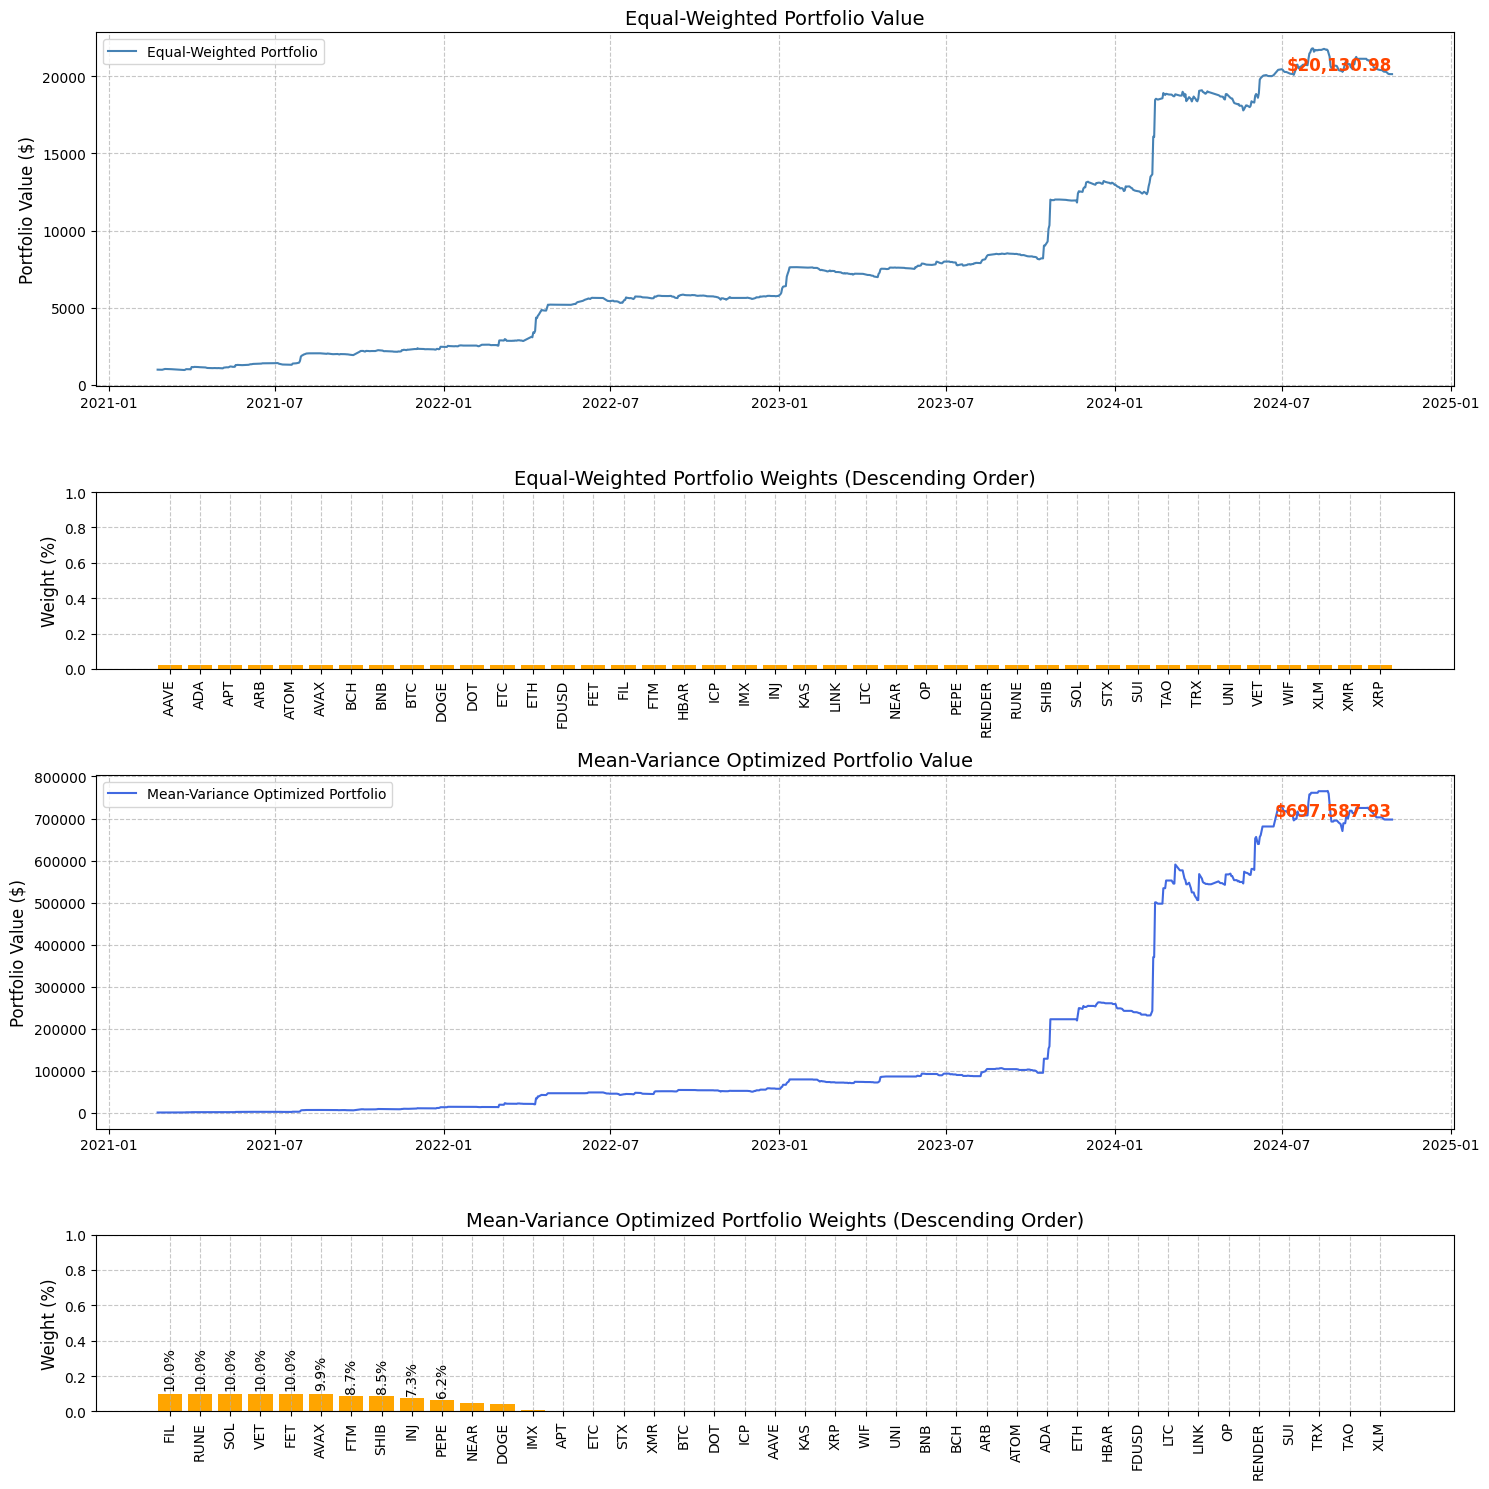

In [ ]:



def mean_variance_optimized_portfolio(returns_matrix, initial_investment=1000, risk_aversion=1,
                                      min_weight=0, max_weight=1, additional_constraints=None):
    """
    Calculates portfolio performance using mean-variance optimization with flexible constraints.

    Parameters:
    - returns_matrix: DataFrame of asset returns.
    - initial_investment: Initial portfolio value.
    - risk_aversion: Risk-aversion parameter.
    - min_weight: Minimum weight for any asset (default: 0).
    - max_weight: Maximum weight for any asset (default: 1).
    - additional_constraints: List of additional constraints (default: None).

    Returns:
    - portfolio_value: Series of portfolio values over time.
    - weights: Array of weights for the assets.
    """
    spearman_corr = returns_matrix.corr(method='spearman')
    variances = returns_matrix.var()
    covariance_matrix = spearman_corr * variances.values[:, None]

    # Regularize covariance matrix to avoid numerical issues
    covariance_matrix += np.eye(len(covariance_matrix)) * 1e-6

    expected_returns = returns_matrix.mean()

    def mvo_objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        return portfolio_variance - risk_aversion * portfolio_return

    # Default constraint: weights sum to 1
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]

    # Add additional constraints if provided
    if additional_constraints:
        constraints.extend(additional_constraints)

    # Dynamic bounds based on min_weight and max_weight
    num_assets = len(returns_matrix.columns)
    bounds = [(min_weight, max_weight) for _ in range(num_assets)]

    # Initial guess: random within bounds
    initial_guess = np.random.uniform(min_weight, max_weight, size=num_assets)
    print("Initial Guess:", initial_guess)

    # Perform optimization
    result = minimize(
        mvo_objective,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': True}
    )

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    mvo_weights = result.x
    # print("Final Weights:", mvo_weights)

    portfolio_returns = returns_matrix.dot(mvo_weights)
    portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

    return portfolio_value, mvo_weights


# def mean_variance_optimized_portfolio(returns_matrix, initial_investment=1000, risk_aversion=1):
#     """
#     Calculates portfolio performance using mean-variance optimization.

#     Parameters:
#     - returns_matrix: DataFrame of asset returns.
#     - initial_investment: Initial portfolio value.
#     - risk_aversion: Risk-aversion parameter.

#     Returns:
#     - portfolio_value: Series of portfolio values over time.
#     - weights: Array of weights for the assets.
#     """
#     spearman_corr = returns_matrix.corr(method='spearman')
#     variances = returns_matrix.var()
#     covariance_matrix = spearman_corr * variances.values[:, None]

#     expected_returns = returns_matrix.mean()

#     def mvo_objective(weights):
#         portfolio_return = np.dot(weights, expected_returns)
#         portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
#         return portfolio_variance - risk_aversion * portfolio_return

#     constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
#     bounds = [(0, 1) for _ in range(len(returns_matrix.columns))]
#     initial_guess = np.ones(len(returns_matrix.columns)) / len(returns_matrix.columns)

#     result = minimize(
#         mvo_objective,
#         initial_guess,
#         method='SLSQP',
#         bounds=bounds,
#         constraints=constraints
#     )

#     if not result.success:
#         raise ValueError(f"Optimization failed: {result.message}")

#     mvo_weights = result.x

#     portfolio_returns = returns_matrix.dot(mvo_weights)
#     portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

#     return portfolio_value, mvo_weights


def plot_portfolio_values(equal_portfolio_value, equal_weights, mvo_portfolio_value, mvo_weights, asset_labels):
    """
    Plots the portfolio values and weights for both Equal-Weighted and Mean-Variance Optimized strategies.
    Adds labels for the bars representing the highest weights, sorted in descending order.

    Parameters:
    - equal_portfolio_value: Series of portfolio values over time for the Equal-Weighted strategy.
    - equal_weights: Array of weights for the Equal-Weighted strategy.
    - mvo_portfolio_value: Series of portfolio values over time for the Mean-Variance Optimized strategy.
    - mvo_weights: Array of weights for the MVO strategy.
    - asset_labels: List of asset names.

    Returns:
    - None: Displays the plots.
    """
    # Ensure weights are converted to pandas Series with asset labels
    equal_weights = pd.Series(equal_weights, index=asset_labels).sort_values(ascending=False)
    mvo_weights = pd.Series(mvo_weights, index=asset_labels).sort_values(ascending=False)

    fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=False, gridspec_kw={'height_ratios': [2, 1, 2, 1]})

    # Equal-weighted portfolio value plot
    axes[0].plot(equal_portfolio_value.index, equal_portfolio_value, label="Equal-Weighted Portfolio", color='steelblue')
    axes[0].set_title("Equal-Weighted Portfolio Value", fontsize=14)
    axes[0].set_ylabel("Portfolio Value ($)", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(loc="upper left", fontsize=10)

    # Annotate final value
    eq_final_value = equal_portfolio_value.iloc[-1]
    eq_final_date = equal_portfolio_value.index[-1]
    axes[0].text(eq_final_date, eq_final_value, f"${eq_final_value:,.2f}", fontsize=12,
                 verticalalignment='bottom', horizontalalignment='right', color='orangered', fontweight='bold')

    # Equal-weighted portfolio weights bar chart
    bars = axes[1].bar(equal_weights.index, equal_weights.values, color='orange')
    axes[1].set_title("Equal-Weighted Portfolio Weights (Descending Order)", fontsize=14)
    axes[1].set_ylabel("Weight (%)", fontsize=12)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].set_xticks(range(len(equal_weights.index)))
    axes[1].set_xticklabels(equal_weights.index, rotation=90)

    # Add labels for assets with the highest weights
    for bar, weight in zip(bars, equal_weights.values):
        if weight > 0.05:  # Add label only if weight > 5%
            axes[1].text(bar.get_x() + bar.get_width() / 2, weight + 0.02, f"{weight:.1%}",
                         ha='center', va='top', fontsize=10, color='black')

    # MVO portfolio value plot
    axes[2].plot(mvo_portfolio_value.index, mvo_portfolio_value, label="Mean-Variance Optimized Portfolio", color='royalblue')
    axes[2].set_title("Mean-Variance Optimized Portfolio Value", fontsize=14)
    axes[2].set_ylabel("Portfolio Value ($)", fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.7)
    axes[2].legend(loc="upper left", fontsize=10)

    # Annotate final value
    mvo_final_value = mvo_portfolio_value.iloc[-1]
    mvo_final_date = mvo_portfolio_value.index[-1]
    axes[2].text(mvo_final_date, mvo_final_value, f"${mvo_final_value:,.2f}", fontsize=12,
                 verticalalignment='bottom', horizontalalignment='right', color='orangered', fontweight='bold')

    # MVO portfolio weights bar chart
    bars = axes[3].bar(mvo_weights.index, mvo_weights.values, color='orange')
    axes[3].set_title("Mean-Variance Optimized Portfolio Weights (Descending Order)", fontsize=14)
    axes[3].set_ylabel("Weight (%)", fontsize=12)
    axes[3].set_ylim(0, 1)
    axes[3].grid(True, linestyle='--', alpha=0.7)
    axes[3].set_xticks(range(len(mvo_weights.index)))
    axes[3].set_xticklabels(mvo_weights.index, rotation=90)

    # Add labels for assets with the highest weights
    for bar, weight in zip(bars, mvo_weights.values):
        if weight > 0.05:  # Add label only if weight > 5%
            axes[3].text(bar.get_x() + bar.get_width() / 2, weight + 0.02, f"{weight:.1%}",
                         ha='center', va='bottom', fontsize=10, color='black', rotation=90)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    csv_file = 'Total Backtest 12H.csv'
    initial_investment = 1000

    # Step 1: Read and prepare dataset
    returns_matrix = read_and_prepare_dataset(csv_file)

    # Step 2: Equal-Weighted Portfolio
    equal_portfolio_value, equal_weights = equal_weighted_portfolio(returns_matrix, initial_investment)

    # Step 3: Mean-Variance Optimized Portfolio
    # mvo_portfolio_value, mvo_weights = mean_variance_optimized_portfolio(returns_matrix, initial_investment)
    portfolio_value, mvo_weights = mean_variance_optimized_portfolio(
    returns_matrix,
    initial_investment=1000,
    risk_aversion=1,
    min_weight=0.0,  # Minimum weight: 1%
    max_weight=0.1   # Maximum weight: 50%
)

    # Step 4: Plot the portfolio values and weights
    plot_portfolio_values(
        equal_portfolio_value,
        equal_weights,
        mvo_portfolio_value,
        mvo_weights,
        asset_labels=returns_matrix.columns.tolist()
    )


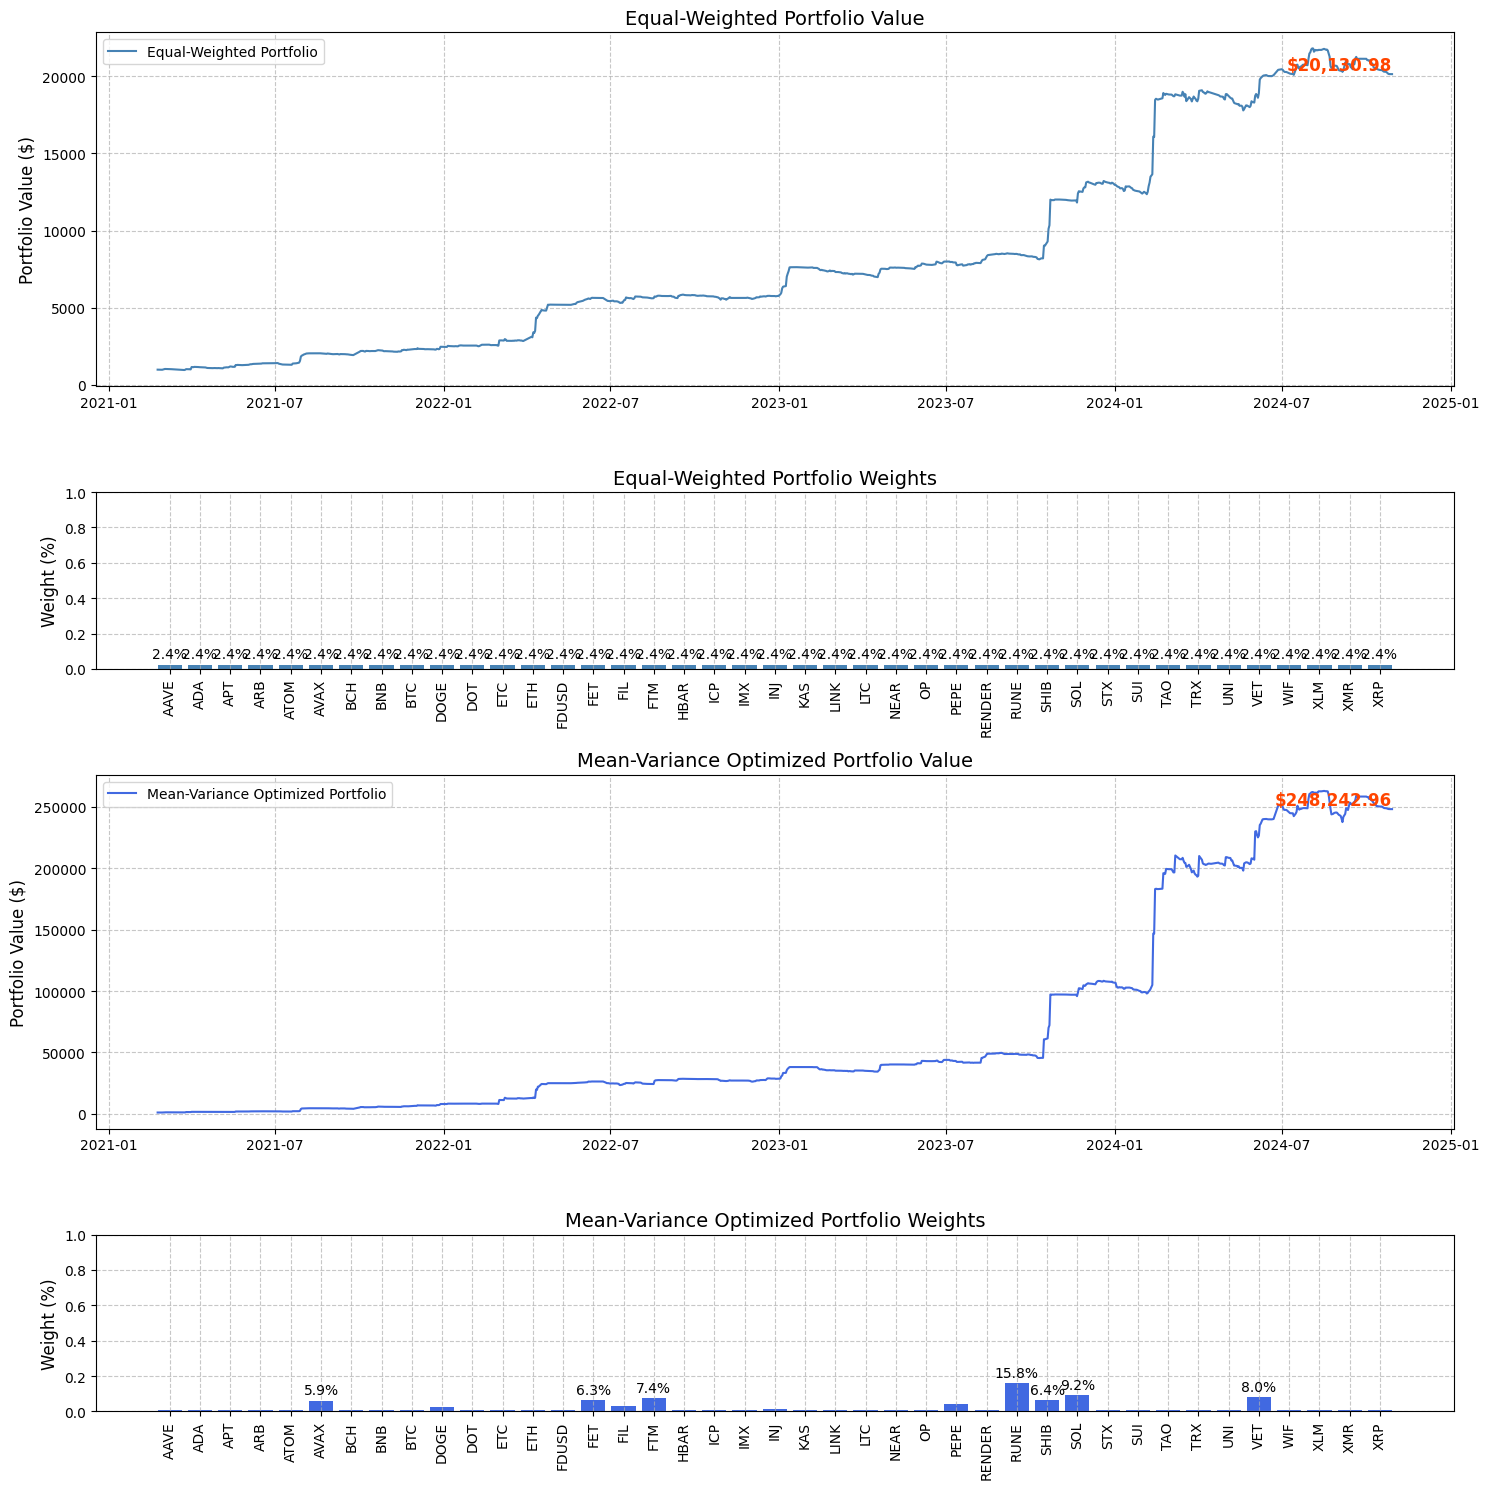

In [16]:
def plot_portfolio_values(equal_portfolio_value, equal_weights, mvo_portfolio_value, mvo_weights, asset_labels):
    """
    Plots the portfolio values and weights for both Equal-Weighted and Mean-Variance Optimized strategies.
    Adds labels for the bars representing the highest weights.

    Parameters:
    - equal_portfolio_value: Series of portfolio values over time for the Equal-Weighted strategy.
    - equal_weights: Array of weights for the Equal-Weighted strategy.
    - mvo_portfolio_value: Series of portfolio values over time for the Mean-Variance Optimized strategy.
    - mvo_weights: Array of weights for the MVO strategy.
    - asset_labels: List of asset names.

    Returns:
    - None: Displays the plots.
    """
    # Ensure weights are converted to pandas Series with asset labels
    equal_weights = pd.Series(equal_weights, index=asset_labels)
    mvo_weights = pd.Series(mvo_weights, index=asset_labels)

    fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=False, gridspec_kw={'height_ratios': [2, 1, 2, 1]})

    # Equal-weighted portfolio value plot
    axes[0].plot(equal_portfolio_value.index, equal_portfolio_value, label="Equal-Weighted Portfolio", color='steelblue')
    axes[0].set_title("Equal-Weighted Portfolio Value", fontsize=14)
    axes[0].set_ylabel("Portfolio Value ($)", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(loc="upper left", fontsize=10)

    # Annotate final value
    eq_final_value = equal_portfolio_value.iloc[-1]
    eq_final_date = equal_portfolio_value.index[-1]
    axes[0].text(eq_final_date, eq_final_value, f"${eq_final_value:,.2f}", fontsize=12,
                 verticalalignment='bottom', horizontalalignment='right', color='orangered', fontweight='bold')

    # Equal-weighted portfolio weights bar chart
    bars = axes[1].bar(equal_weights.index, equal_weights.values, color='steelblue')
    axes[1].set_title("Equal-Weighted Portfolio Weights", fontsize=14)
    axes[1].set_ylabel("Weight (%)", fontsize=12)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].set_xticks(range(len(equal_weights.index)))
    axes[1].set_xticklabels(equal_weights.index, rotation=90)

    # Add labels for assets with the highest weights
    for bar, weight, label in zip(bars, equal_weights.values, equal_weights.index):
        if weight > 0.0:  # Add label only if weight > 10%
            axes[1].text(bar.get_x() + bar.get_width() / 2, weight + 0.02, f"{weight:.1%}",
                         ha='center', va='bottom', fontsize=10, color='black')

    # MVO portfolio value plot
    axes[2].plot(mvo_portfolio_value.index, mvo_portfolio_value, label="Mean-Variance Optimized Portfolio", color='royalblue')
    axes[2].set_title("Mean-Variance Optimized Portfolio Value", fontsize=14)
    axes[2].set_ylabel("Portfolio Value ($)", fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.7)
    axes[2].legend(loc="upper left", fontsize=10)

    # Annotate final value
    mvo_final_value = mvo_portfolio_value.iloc[-1]
    mvo_final_date = mvo_portfolio_value.index[-1]
    axes[2].text(mvo_final_date, mvo_final_value, f"${mvo_final_value:,.2f}", fontsize=12,
                 verticalalignment='bottom', horizontalalignment='right', color='orangered', fontweight='bold')

    # MVO portfolio weights bar chart
    bars = axes[3].bar(mvo_weights.index, mvo_weights.values, color='royalblue')
    axes[3].set_title("Mean-Variance Optimized Portfolio Weights", fontsize=14)
    axes[3].set_ylabel("Weight (%)", fontsize=12)
    axes[3].set_ylim(0, 1)
    axes[3].grid(True, linestyle='--', alpha=0.7)
    axes[3].set_xticks(range(len(mvo_weights.index)))
    axes[3].set_xticklabels(mvo_weights.index, rotation=90)

    # Add labels for assets with the highest weights
    for bar, weight, label in zip(bars, mvo_weights.values, mvo_weights.index):
        if weight > 0.05:  # Add label only if weight > 10%
            axes[3].text(bar.get_x() + bar.get_width() / 2, weight + 0.02, f"{weight:.1%}",
                         ha='center', va='bottom', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    csv_file = 'Total Backtest 12H.csv'
    initial_investment = 1000

    # Step 1: Read and prepare dataset
    returns_matrix = read_and_prepare_dataset(csv_file)

    # Step 2: Equal-Weighted Portfolio
    equal_portfolio_value, equal_weights = equal_weighted_portfolio(returns_matrix, initial_investment)

    # Step 3: Mean-Variance Optimized Portfolio
    mvo_portfolio_value, mvo_weights = mean_variance_optimized_portfolio(returns_matrix, initial_investment)

    # Step 4: Plot the portfolio values and weights
    plot_portfolio_values(
        equal_portfolio_value,
        equal_weights,
        mvo_portfolio_value,
        mvo_weights,
        asset_labels=returns_matrix.columns.tolist()
    )

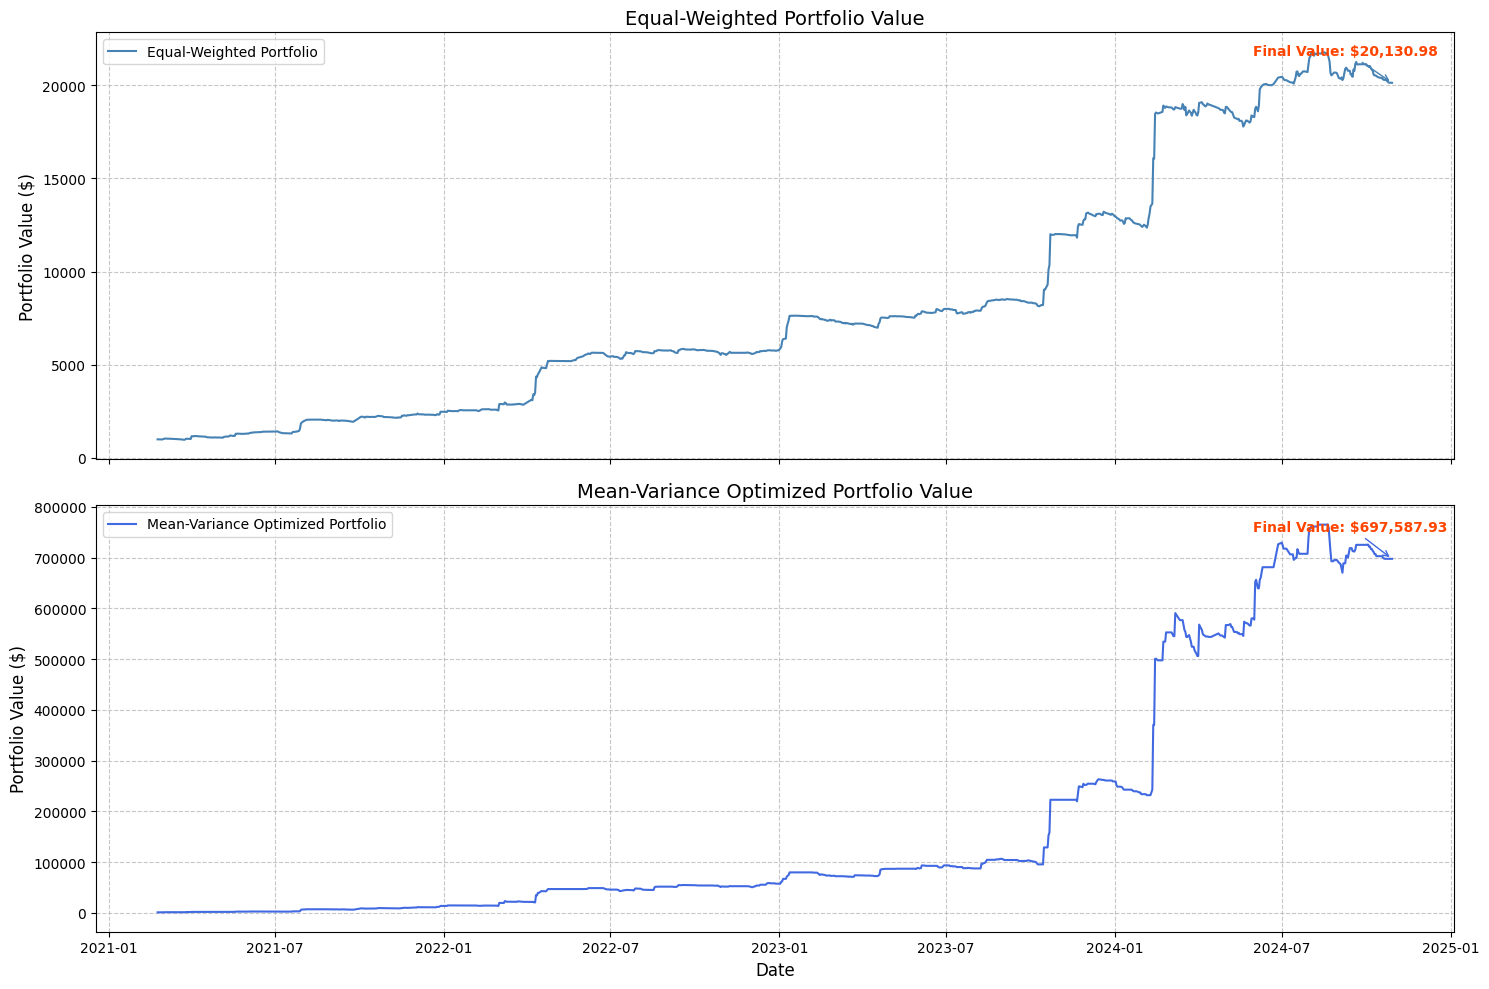


Equal-Weighted Portfolio Weights:
AAVE: 2.439%
ADA: 2.439%
APT: 2.439%
ARB: 2.439%
ATOM: 2.439%
AVAX: 2.439%
BCH: 2.439%
BNB: 2.439%
BTC: 2.439%
DOGE: 2.439%
DOT: 2.439%
ETC: 2.439%
ETH: 2.439%
FDUSD: 2.439%
FET: 2.439%
FIL: 2.439%
FTM: 2.439%
HBAR: 2.439%
ICP: 2.439%
IMX: 2.439%
INJ: 2.439%
KAS: 2.439%
LINK: 2.439%
LTC: 2.439%
NEAR: 2.439%
OP: 2.439%
PEPE: 2.439%
RENDER: 2.439%
RUNE: 2.439%
SHIB: 2.439%
SOL: 2.439%
STX: 2.439%
SUI: 2.439%
TAO: 2.439%
TRX: 2.439%
UNI: 2.439%
VET: 2.439%
WIF: 2.439%
XLM: 2.439%
XMR: 2.439%
XRP: 2.439%

Mean-Variance Optimized Portfolio Weights:
AAVE: 0.000%
ADA: 0.000%
APT: 0.000%
ARB: 0.000%
ATOM: 0.000%
AVAX: 8.846%
BCH: 0.000%
BNB: 0.000%
BTC: 0.000%
DOGE: 3.410%
DOT: 0.000%
ETC: 0.000%
ETH: 0.000%
FDUSD: 0.000%
FET: 9.333%
FIL: 8.103%
FTM: 7.934%
HBAR: 0.000%
ICP: 0.000%
IMX: 0.000%
INJ: 5.310%
KAS: 0.000%
LINK: 0.000%
LTC: 0.000%
NEAR: 3.119%
OP: 0.000%
PEPE: 5.482%
RENDER: 0.000%
RUNE: 18.293%
SHIB: 7.463%
SOL: 9.841%
STX: 0.000%
SUI: 0.000%
TAO:

In [2]:
# ! pip install pandas numpy matplotlib scipy skfolio

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from skfolio.optimization import EqualWeighted


def compare_portfolio_methods(csv_file, initial_investment=1000, risk_aversion=1):
    """
    Compare portfolio performance using Equal-Weighted and Mean-Variance Optimization.
    
    Parameters:
    - csv_file: Path to the CSV file containing asset returns.
    - initial_investment: Initial portfolio value (default is 1000).
    - risk_aversion: Risk-aversion parameter for mean-variance optimization (default is 1).
    
    Returns:
    - None: Plots the results for both methods.
    """
    # Step 1: Read and preprocess the CSV file
    df = pd.read_csv(csv_file, parse_dates=['EntryTime', 'ExitDate']).fillna(0)

    # Prepare relevant columns
    cols = ['slug', 'EntryTime', 'ExitDate', 'return']

    # Format EntryTime and ExitDate as strings
    df['EntryTime'] = df['EntryTime'].dt.strftime('%Y-%m-%d')
    df['ExitDate'] = df['ExitDate'].dt.strftime('%Y-%m-%d')

    # Create a DataFrame and sort
    return_df = df[cols].sort_values(by=['slug', 'EntryTime']).reset_index(drop=True)

    # Pivot to create a returns matrix
    returns_matrix = return_df.pivot_table(
        index='EntryTime',   # Index is EntryTime
        columns='slug',      # Columns are slugs (assets)
        values='return'      # Values are the returns
    ).fillna(0)

    # Convert index to datetime and sort
    returns_matrix.index = pd.to_datetime(returns_matrix.index)
    returns_matrix = returns_matrix.sort_index()

    # Define consistent colors
    equal_color = 'steelblue'
    mvo_color = 'royalblue'

    # Step 2: Equal-Weighted Portfolio
    equal_weighted_portfolio = EqualWeighted()
    optimized_equal = equal_weighted_portfolio.fit(returns_matrix)
    equal_weights = optimized_equal.weights_

    # Portfolio value for equal-weighted approach
    equal_portfolio_returns = returns_matrix.dot(equal_weights)
    equal_portfolio_value = initial_investment * (1 + equal_portfolio_returns).cumprod()

    # Step 3: Mean-Variance Optimized Portfolio
    # Calculate covariance matrix using Spearman correlation
    spearman_corr = returns_matrix.corr(method='spearman')
    variances = returns_matrix.var()
    covariance_matrix = spearman_corr * variances.values[:, None]

    # Define expected returns
    expected_returns = returns_matrix.mean()

    # Define the optimization objective function
    def mvo_objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        return portfolio_variance - risk_aversion * portfolio_return

    # Constraints and bounds for MVO
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(0, 1) for _ in range(len(returns_matrix.columns))]
    initial_guess = np.ones(len(returns_matrix.columns)) / len(returns_matrix.columns)

    # Optimize weights for MVO
    result = minimize(
        mvo_objective,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    mvo_weights = result.x

    # Portfolio value for MVO approach
    mvo_portfolio_returns = returns_matrix.dot(mvo_weights)
    mvo_portfolio_value = initial_investment * (1 + mvo_portfolio_returns).cumprod()

    # Step 4: Plot the results in subplots
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Equal-weighted plot
    axes[0].plot(equal_portfolio_value.index, equal_portfolio_value, label="Equal-Weighted Portfolio", color=equal_color)
    axes[0].set_title("Equal-Weighted Portfolio Value", fontsize=14)
    axes[0].set_ylabel("Portfolio Value ($)", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(loc="upper left", fontsize=10)

    # Annotate final value
    eq_final_value = equal_portfolio_value.iloc[-1]
    eq_final_date = equal_portfolio_value.index[-1]
    axes[0].annotate(
        f"Final Value: ${eq_final_value:,.2f}",
        xy=(eq_final_date, eq_final_value),
        xytext=(-100, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color=equal_color),
        fontsize=10,
        color="orangered",
        fontweight='bold'
    )

    # MVO plot
    axes[1].plot(mvo_portfolio_value.index, mvo_portfolio_value, label="Mean-Variance Optimized Portfolio", color=mvo_color)
    axes[1].set_title("Mean-Variance Optimized Portfolio Value", fontsize=14)
    axes[1].set_xlabel("Date", fontsize=12)
    axes[1].set_ylabel("Portfolio Value ($)", fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].legend(loc="upper left", fontsize=10)

    # Annotate final value
    mvo_final_value = mvo_portfolio_value.iloc[-1]
    mvo_final_date = mvo_portfolio_value.index[-1]
    axes[1].annotate(
        f"Final Value: ${mvo_final_value:,.2f}",
        xy=(mvo_final_date, mvo_final_value),
        xytext=(-100, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color=mvo_color),
        fontsize=10,
        color="orangered",
        fontweight='bold'
    )

    plt.tight_layout()
    plt.show()

    # Print weights for each method
    print("\nEqual-Weighted Portfolio Weights:")
    for asset, weight in zip(returns_matrix.columns, equal_weights):
        print(f"{asset}: {weight:.3%}")

    print("\nMean-Variance Optimized Portfolio Weights:")
    for asset, weight in zip(returns_matrix.columns, mvo_weights):
        print(f"{asset}: {weight:.3%}")


# Example Usage
if __name__ == "__main__":
    csv_file = 'Total Backtest 12H.csv'
    compare_portfolio_methods(csv_file)
